# Clustering the Countries by using Unsupervised Learning for HELP International
# Problem Statement
Identify the countries that are in most need of aid. Categorize countries according socio-economic factors and determine the overall development level of the country. Then recommend countries that need the most attention.

# Import data and important libraries 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_colwidth', None)
import folium
import requests
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv
/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv


In [2]:
data = pd.read_csv("../input/unsupervised-learning-on-country-data/Country-data.csv")
data_dictionary = pd.read_csv("../input/unsupervised-learning-on-country-data/data-dictionary.csv")

# Data Understanding 

In [3]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
data_dictionary

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


In [5]:
data.shape

(167, 10)

In [6]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


<AxesSubplot:>

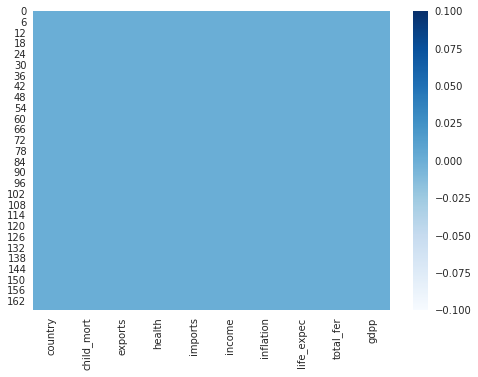

In [7]:
sns.heatmap(data.isna(), cmap="Blues")

# Data Preparation
In order to perform K-means clustering, we need to make sure that the features are normally distributed and there are not highly correlated features.

Text(0.5, 1.0, ' Correlation Heatmap')

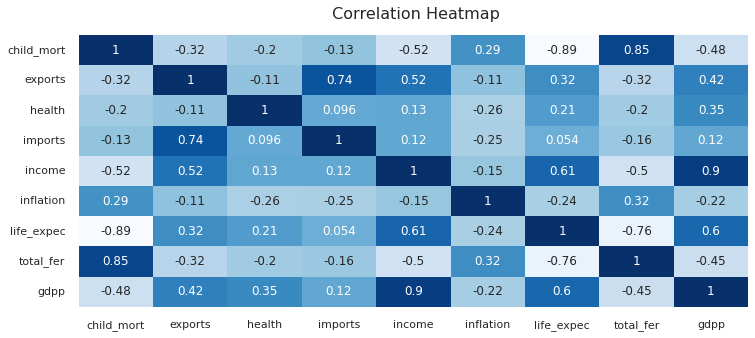

In [8]:
sns.set(rc={"figure.figsize":(12, 5)})
sns.heatmap(data.corr(),annot = True, cbar = False, cmap = "Blues").set_title(" Correlation Heatmap" , fontdict={'fontsize':16}, pad=16)


Life Expectancy and Total Fertility are **higlhy correlated** with Child Mortality. The coefficients are **-0.89 and 0.85**, respectively. Therefore, we have to remove these features.

In [9]:
countries = data["country"]
data1 = data.drop(columns = ["country","life_expec","total_fer","income"])
data1.shape

(167, 6)

<AxesSubplot:xlabel='child_mort', ylabel='Density'>

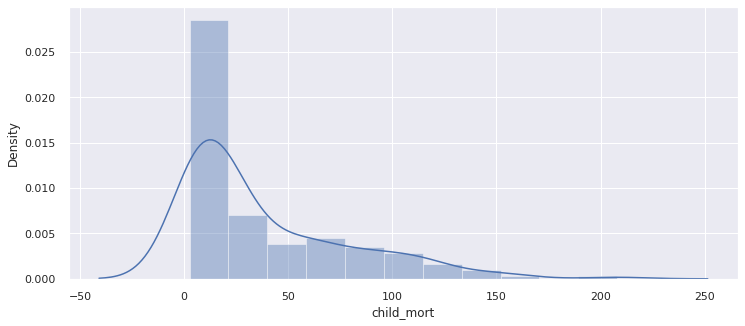

In [10]:
sns.distplot(data1["child_mort"])

<AxesSubplot:xlabel='exports', ylabel='Density'>

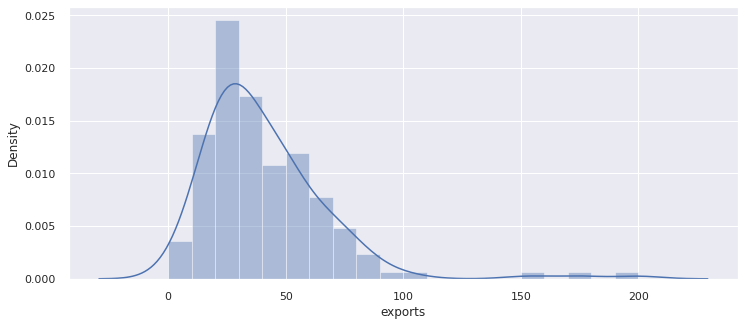

In [11]:
sns.distplot(data1["exports"])

<AxesSubplot:xlabel='health', ylabel='Density'>

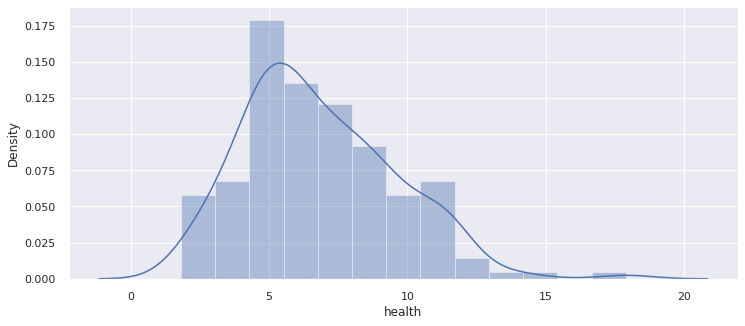

In [12]:
sns.distplot(data1["health"])

<AxesSubplot:xlabel='imports', ylabel='Density'>

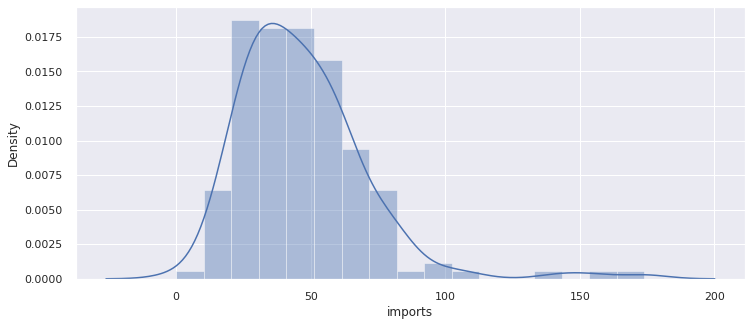

In [13]:
sns.distplot(data1["imports"])

<AxesSubplot:xlabel='inflation', ylabel='Density'>

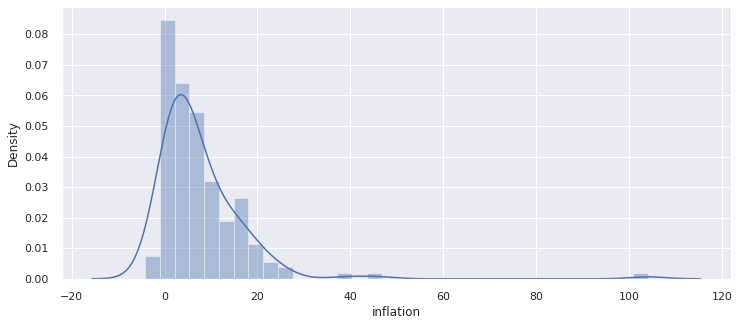

In [14]:
sns.distplot(data1["inflation"])

<AxesSubplot:xlabel='gdpp', ylabel='Density'>

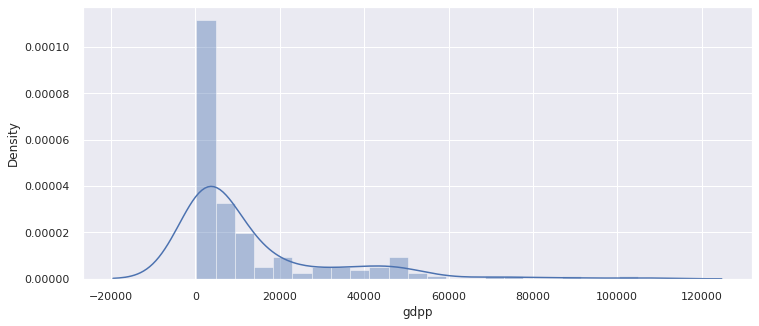

In [15]:
sns.distplot(data1["gdpp"])

Some are close to normal, while others are very higlhy skewed. We have to scale every feature. 

In [16]:
scaler = StandardScaler()
scaler.fit(data1)
data1 = scaler.transform(data1)

# Modeling

## Elbow Method for Optimal Clusters

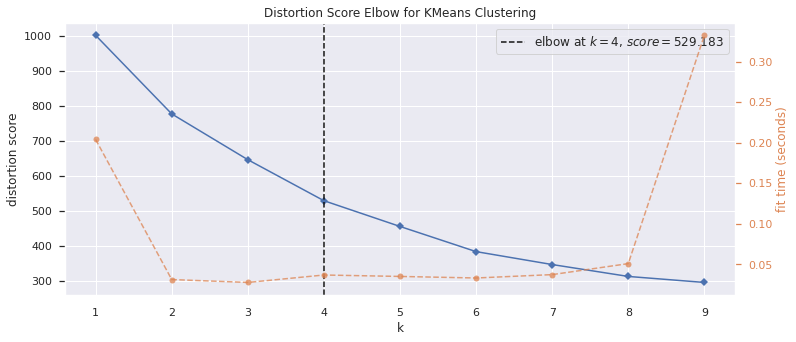

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,10))
visualize.fit(data1)
visualize.poof()

In [18]:
model = KMeans(n_clusters=4, random_state=17093)
model.fit(data1)

KMeans(n_clusters=4, random_state=17093)

In [19]:
data["clusters"] = model.labels_
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,3
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,3


# Evaluation

In [20]:
data["clusters"].value_counts()


3    70
1    69
0    25
2     3
Name: clusters, dtype: int64

### Cluster 1

In [21]:
cluster1  = data[data.clusters == 0]
cluster1.shape

(25, 11)

In [22]:
cluster1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,0
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,0
10,Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000,0
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,0
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,0


In [23]:
list(cluster1["country"])

['Australia',
 'Austria',
 'Bahamas',
 'Belgium',
 'Canada',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Iceland',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Portugal',
 'Qatar',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Kingdom',
 'United States']

In [24]:
cluster1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.0
mean,4.864000,41.364000,10.060400,37.888000,42960.000000,1.491600,80.552000,1.82320,45716.000000,0.0
std,2.321795,21.438514,2.603642,17.172903,19146.714252,2.258291,1.720736,0.36793,15125.190908,0.0
min,2.600000,12.400000,1.810000,13.600000,22900.000000,-3.220000,73.800000,1.37000,22500.000000,0.0
25%,3.900000,26.800000,9.400000,28.000000,35800.000000,0.351000,80.000000,1.48000,35800.000000,0.0
50%,4.200000,35.000000,9.640000,32.900000,40400.000000,0.991000,80.700000,1.87000,44500.000000,0.0
75%,4.800000,51.300000,11.300000,43.600000,44000.000000,1.880000,81.500000,1.98000,50300.000000,0.0
max,13.800000,103.000000,17.900000,86.500000,125000.000000,6.980000,82.800000,3.03000,87800.000000,0.0


### Cluster 2

In [25]:
cluster2  = data[data.clusters == 1]
cluster2.shape

(69, 11)

In [26]:
cluster2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
5,Argentina,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300,1
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.80,69.1,1.92,5840,1


In [27]:
list(cluster2["country"])

['Afghanistan',
 'Algeria',
 'Angola',
 'Argentina',
 'Azerbaijan',
 'Bangladesh',
 'Benin',
 'Bolivia',
 'Brazil',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Dominican Republic',
 'Egypt',
 'Equatorial Guinea',
 'Eritrea',
 'Gabon',
 'Gambia',
 'Ghana',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Kazakhstan',
 'Kenya',
 'Lao',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mongolia',
 'Mozambique',
 'Myanmar',
 'Nepal',
 'Niger',
 'Nigeria',
 'Pakistan',
 'Peru',
 'Philippines',
 'Russia',
 'Rwanda',
 'Saudi Arabia',
 'Senegal',
 'Sierra Leone',
 'South Africa',
 'Sri Lanka',
 'Sudan',
 'Tajikistan',
 'Tanzania',
 'Timor-Leste',
 'Togo',
 'Turkey',
 'Uganda',
 'Uzbekistan',
 'Venezuela',
 'Yemen',
 'Zambia']

In [28]:
cluster2.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.0
mean,69.904348,27.924623,5.660000,33.909651,6869.608696,13.260507,64.362319,4.116232,3226.391304,1.0
std,42.517479,16.499992,2.164893,13.101442,8103.479110,13.986192,8.266376,1.545297,4111.227623,0.0
min,10.000000,0.109000,1.970000,0.065900,609.000000,0.885000,32.100000,1.570000,231.000000,1.0
25%,34.400000,17.100000,4.410000,25.500000,1610.000000,5.450000,58.700000,2.600000,648.000000,1.0
50%,63.700000,24.300000,5.180000,33.300000,3370.000000,10.100000,65.300000,4.510000,1310.000000,1.0
75%,97.400000,35.400000,6.740000,43.000000,9860.000000,16.600000,69.900000,5.310000,4460.000000,1.0
max,208.000000,85.800000,13.100000,64.700000,45400.000000,104.000000,78.200000,7.490000,19300.000000,1.0


### Cluster 3

In [29]:
cluster3 = data[data.clusters == 2]
cluster3.shape

(3, 11)

In [30]:
cluster3.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000,2
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,2
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,2


In [31]:
list(cluster3["country"])

['Luxembourg', 'Malta', 'Singapore']

In [32]:
cluster3.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667,2.0
std,2.309401,23.515952,2.492877,16.165808,32460.642836,2.179718,1.205543,0.240624,43011.665084,0.0
min,2.800000,153.000000,3.960000,142.000000,28300.000000,-0.046000,80.300000,1.150000,21100.000000,2.0
25%,2.800000,164.000000,5.865000,148.000000,50200.000000,1.787000,80.800000,1.255000,33850.000000,2.0
50%,2.800000,175.000000,7.770000,154.000000,72100.000000,3.620000,81.300000,1.360000,46600.000000,2.0
75%,4.800000,187.500000,8.210000,164.000000,81900.000000,3.725000,82.000000,1.495000,75800.000000,2.0
max,6.800000,200.000000,8.650000,174.000000,91700.000000,3.830000,82.700000,1.630000,105000.000000,2.0


### Cluster 4

In [33]:
cluster4 = data[data.clusters == 3]
cluster4.shape

(70, 11)

In [34]:
cluster4.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,3
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,3
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,3
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,3
13,Barbados,14.2,39.5,7.97,48.7,15300,0.321,76.7,1.78,16000,3


In [35]:
list(cluster4["country"])

['Albania',
 'Antigua and Barbuda',
 'Armenia',
 'Bahrain',
 'Barbados',
 'Belarus',
 'Belize',
 'Bhutan',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brunei',
 'Bulgaria',
 'Cambodia',
 'Cape Verde',
 'Chile',
 'Costa Rica',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Ecuador',
 'El Salvador',
 'Estonia',
 'Fiji',
 'Georgia',
 'Grenada',
 'Guyana',
 'Hungary',
 'Jamaica',
 'Jordan',
 'Kiribati',
 'Kuwait',
 'Kyrgyz Republic',
 'Latvia',
 'Lebanon',
 'Lesotho',
 'Liberia',
 'Libya',
 'Lithuania',
 'Macedonia, FYR',
 'Malaysia',
 'Maldives',
 'Mauritius',
 'Micronesia, Fed. Sts.',
 'Moldova',
 'Montenegro',
 'Morocco',
 'Namibia',
 'Oman',
 'Panama',
 'Paraguay',
 'Poland',
 'Romania',
 'Samoa',
 'Serbia',
 'Seychelles',
 'Slovak Republic',
 'Slovenia',
 'Solomon Islands',
 'South Korea',
 'St. Vincent and the Grenadines',
 'Suriname',
 'Thailand',
 'Tonga',
 'Tunisia',
 'Turkmenistan',
 'Ukraine',
 'United Arab Emirates',
 'Uruguay',
 'Vanuatu',
 'Vietnam']

In [36]:
cluster4.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.0
mean,20.481429,48.232857,6.797000,58.195714,16043.714286,4.855671,72.624286,2.265286,8954.185714,3.0
std,18.775673,18.630999,2.417564,16.711104,15082.282645,4.457253,6.148794,0.841687,8489.312803,0.0
min,3.200000,12.400000,2.500000,25.400000,700.000000,-4.210000,46.500000,1.230000,327.000000,3.0
25%,8.625000,32.975000,5.200000,48.075000,6870.000000,1.615000,70.625000,1.570000,3250.000000,3.0
50%,14.950000,48.050000,6.615000,57.500000,12050.000000,3.740000,74.050000,2.135000,6130.000000,3.0
75%,24.100000,65.050000,8.022500,66.750000,19925.000000,7.397500,76.475000,2.670000,12075.000000,3.0
max,99.700000,93.800000,14.200000,108.000000,80600.000000,16.700000,80.400000,5.020000,38500.000000,3.0


# Interpretation and Recommendation

In [37]:
mean_data = pd.DataFrame(data.mean()) 
mean_data["Cluster 1"] = cluster1.mean()
mean_data["Cluster 2 "] = cluster2.mean()
mean_data["Cluster 3 "] = cluster3.mean()
mean_data["Cluster 4"] = cluster4.mean()
mean_data.rename(columns={0: "Whole Data"}, inplace = True)
mean_data


,Whole Data,Cluster 1,Cluster 2,Cluster 3,Cluster 4
child_mort,38.270060,4.8640,69.904348,4.133333,20.481429
exports,41.108976,41.3640,27.924623,176.000000,48.232857
health,6.815689,10.0604,5.660000,6.793333,6.797000
imports,46.890215,37.8880,33.909651,156.666667,58.195714
income,17144.688623,42960.0000,6869.608696,64033.333333,16043.714286
inflation,7.781832,1.4916,13.260507,2.468000,4.855671
life_expec,70.555689,80.5520,64.362319,81.433333,72.624286
total_fer,2.947964,1.8232,4.116232,1.380000,2.265286
gdpp,12964.155689,45716.0000,3226.391304,57566.666667,8954.185714
clusters,1.706587,0.0000,1.000000,2.000000,3.000000


According to the averages, countries in cluster 2 have the worst socio-economic and health indicators. Therefore, these countries are in the direst need for help.